# Intro: Analyzer of text related to Food Security





🎯 **Goal**: Analyze the input text to identify the food insecurity risk factors, the geographical scope and relevant named-entities.

✅ **Tasks**:
* NER on locations, time, and organizations.
* NER on risk factors from expert's lexicon.
* Sentiment analysis of neutral terms related to prices, food production and farming materials.

⭕ **Pending tasks**
* Entity linking "Risk factor" - DATE - DURATION - PLACE

🐱‍👤 **GitHub repository**: https://github.com/tetis-nlp/food-insecurity-risk-mining/

**Team members**:

| Member      | Affiliation            | Role |
|-------------|------------------------|-------------|
| Nelson JAIMES-QUINTERO    | INRAE / TETIS - Univ. de Strasbourg      |Author - intern|
| [Maguelonne TEISSEIRE](https://umr-tetis.fr/index.php/fr/equipe-misca/maguelone-teisseire) | INRAE / TETIS            |Supervisor|
| [Sarah VALENTIN](https://www.scopus.com/authid/detail.uri?authorId=57203356039)  | CIRAD / TETIS |Supervisor|


**Publication date**: 07-2024

**Research lab**: TETIS - [Maison de la télédétection](https://www.teledetection.fr/index.php/en/organizations/umr-tetis) (Montpellier, FRANCE)

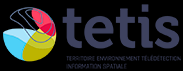

# 💡 1. Basic concepts
##1.2 What is food security?
Is food... 📦available? 💸🚚accessible? 🤢safe? 🏜️sustainable?

A more technical definition is proposed by the High Level Panel of Experts on Food Security and Nutrition (HLPE-FN) of the Committee on World Food Security ([Rome, 2020](https://www.fao.org/cfs/cfs-hlpe/publications/hlpe-15/en)) :


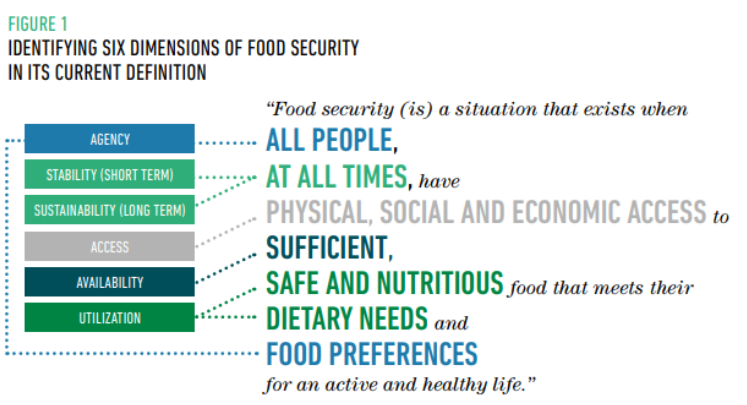

## 1.2 What causes food insecurity?
Many factors of diferent dimensions such as: crop yields, weather conditions, food prices, farming material's prices and availability, invasive species, irrational land use, terrorism, etc. ([See a bibliographical review of the many causes and how they are measured](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10161169/))

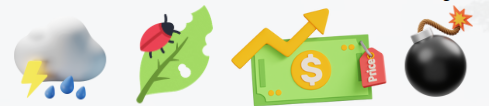

## 1.3 How can we use NLP to detect risk factors?
We can analyze press articles to monitor the apparition or evolution of events linked to possible causes of food insecurity. This will help to explain why a specific region is vulnerable to food insecurity.

Some possible causes are easy to detect, for instance:
* "inflation", "war", "bad harvest", "earthquake";
* but some other possible causes might be expressed in many different ways "the crops of **{CEREAL: sorgho|millet|oat}** were **{MODIFIER: severely|incredibly}** **{negative VERB: affected|destroyed}** by the **{AGENT: rain|ProperNounOfCriminals}**", even with idioms.


Given this complexity in how media talk about events, we propose:
* to identify words with high probability of be a direct or indirect cause of food insecurity (war, terrorism, inflation, natural disasters, etc.), and
* to identify sentences with possible but not probable causes of food insecurity: ("harvest" -> Is something negative happening to the harvests?)

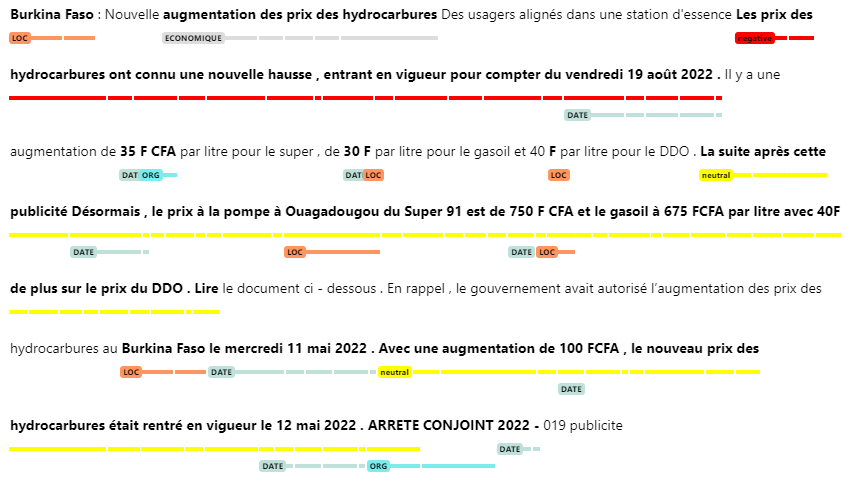

In [ ]:
#@title *2. Requirements* { display-mode: "form", run: "auto" }
#Code created by Nelson JAIMES-QUINTERO
#@markdown # **Prepare the code**
#@markdown Execute (click on ▶ at your left) to install necessary packages and modules

#@markdown No need to mount on Google Drive.
''
!pip install pandas
!pip install tqdm
!pip install spacy
!pip install spacy-lefff
!pip install vaderSentiment_fr
!pip install transformers
!pip install --upgrade ipywidgets
!pip install torch
!python -m spacy download fr_core_news_lg

!pip install JPype1==1.5.0
!pip install langchain
!pip install langchain_community
!pip install langchain_core
!pip install langchain-openai

!pip install timexy

!pip install py_heideltime

# imports
import pandas as pd
import os
import re
import ast
import spacy
import json
from spacy.pipeline import EntityRuler
from spacy.language import Language
from timexy import Timexy

# Sentiment with VaderFR
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

# Sentiment with Transformers - Hugging Face - no tensorflow
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Sentiment with Ollama models
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate

# Temporal expressions with HeidelTime python wrapper
from datetime import datetime
from dateutil.parser import parse
from py_heideltime import heideltime

# montpellier API key
from langchain_community.chat_models import ChatOllama
from langchain_openai import ChatOpenAI

# Download expert lexicon from https://github.com/tetis-nlp/food-insecurity-risk-mining/raw/main/src/df_lex_variants.xlsx
!wget https://github.com/tetis-nlp/food-insecurity-risk-mining/raw/main/src/df_lex_variants.xlsx -P /content

big_test_doc = """La guerre est mauvaise car il monte le coût de l'engrais depuis hier.
Si les prix du coton ont chuté de 25% au mois de septembre pour clôturer le 30 septembre à 85,34 cents la livre, le moral des participants n’était pas en berne.
Les légumes sont frais en 2020.
Les incendies et une incendie en Inde a détruit la forêt et causé une sécheresse sans précédentes pour six mois.
Les aliments sont sains.
Le niveau de sous-alimentation a atteint un niveau préoccupant, il faut donc améliorer le système agro-alimentaire. Dernière phrase."""


In [ ]:
# This notebook is designed to be run in CPU mode. If you want to run it in GPU mode, the code is not optimized for that.
# Execute the following code to ensure your installed torch version is only CPU mode.
# Warning: a cuda version of torch might be compatible with CPU, but if it is not, you can reinstall torch for CPU only with the following code:

#!pip uninstall -y torch
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
import torch
print(torch.__version__)

# If you have the problem "numpy.dtype size changed, may indicate binary incompatibility" with numpy and spacy, follow this https://stackoverflow.com/a/51587845

In [ ]:
#@title *3. Set functions and hyperparameters* { display-mode: "form", run: "auto" }
#@markdown # **Load these parameters by default.**
#@markdown ## Just click on ▶ and we'll be back here when starting **section 4.3**.
#@markdown ---
#@markdown ## 📄 Set the name of your local Ollama model 📁 **([Install your server here](https://ollama.com/download)**):
import os
import getpass
from IPython.display import display
import ipywidgets as widgets
import logging
LLM_MODEL = "phi3:3.8b-mini-instruct-4k-q4_K_M" #@param {type:"string"}

#@markdown ---
#@markdown ## Input path of the expert's lexicon
#@markdown By default, the code will download the Excel file in the content folder 📁 "/content/df_lex_variants.xlsx". Change only to try a new expert lexicon.
EXPERT_LEXICON_PATH = '/content/df_lex_variants.xlsx' #@param {type:"string"}


SPACY_MODEL = 'fr_core_news_lg'
OPENAI_API_KEY = None
ISDM_TOKEN = None

# Load the expert lexicon (lexique d'Annotation)

def load_vocabulary(vocabulary_path):
    """
    Load a vocabulary from an Excel file containing two columns: word and category
    :param vocabulary_path: path to the Excel file
    :return: two dictionaries with {theme: {concept: [terms]}}, where terms is a list of words, there are many concepts per theme, and many terms per concept
    """
    # Read the xlsx file as a dataframe
    lex = pd.read_excel(vocabulary_path, header=0)

    # Create two empty dictionaries
    polarized_variants_dict = {}
    neutral_variants_dict = {}

    # Iterate over each row in the dataframe
    for index, row in lex.iterrows():
        concept = row['concept']
        variants = ast.literal_eval(row['terms']) + [concept] if pd.notna(row['terms']) else [concept]

        # Check if the theme already exists in the dictionary
        if row['theme'] in (polarized_variants_dict if row['neutral'] == 0 else neutral_variants_dict):
            # If it does, append the new concept and its variants
            (polarized_variants_dict if row['neutral'] == 0 else neutral_variants_dict)[row['theme']][concept] = variants
        else:
            # If it doesn't, create a new dictionary for this theme
            (polarized_variants_dict if row['neutral'] == 0 else neutral_variants_dict)[row['theme']] = {concept: variants}

    return [polarized_variants_dict, neutral_variants_dict]

def get_expert_PolarizedConcepts(vocabulary: dict) -> list:
    """
    Get the expert polarized concepts from the given vocabulary.

    Args:
        vocabulary (dict): A dictionary containing the vocabulary with this structure: {theme:{broad_concept:[concept_variants]}}.

    Returns:
        list: A list of expert polarized concepts (broad_concepts) that are not neutral.

    """
    expert_concepts = []
    # Iterate over the outer dictionary
    for key1 in vocabulary:
        # Iterate over the inner dictionary
        for key2 in vocabulary[key1]:
            # Check if the key does not start with 'neutral'
            #if not key2.startswith('neutral'):
                # Add the key to the list
            expert_concepts.append(key2)
    return expert_concepts

polarized_vocabulary = load_vocabulary(EXPERT_LEXICON_PATH)[0]  # exemple -- {'environment': {'aléa': ['aléa'], 'catastrophe naturelle': ['catastrophe naturelle']}}
neutral_vocabulary = load_vocabulary(EXPERT_LEXICON_PATH)[1]  # exemple -- {'economique': {'neutral prix': ['prix', 'coût']}}
# Add a list of cereals and food in French
cereals = ['mil', 'sorgho', 'maïs', 'blé',  'millet', 'manioc', 'riz', 'sorgo', "céréale"]
food = ["arachides", "date de semis","denrée alimentaire","développement de culture","laitiers","légume","légumineux","farine","fruit","haricot","engrai","poisson","niébé","viande","vivres","plantation","ressource alimentaire","denrée"]
# Add new patterns for the custom new lists from WordNet : cereals, food
cereals_wordnet = ['atole', 'granola', 'Porridge', 'porridge', 'polenta', 'Avena', 'avoine', 'maïs soufflé', 'maïs éclaté', 'pop-corn', 'riz brun', 'riz cargo', 'riz complet', 'gruau', 'zizanie', 'blé noir', 'sarrasin', 'blé', 'froment', 'rizière', 'maïs', 'millet', 'boulghour', 'boulgour', 'riz', 'malt', 'orge', 'maïs', 'maïs doux', 'maïs sucré', 'riz blanc', 'Avena', 'avoine', 'blé tendre', 'froment', 'triticum aestivum', 'orge', 'avena fatua', 'folle avoine', 'avena barbata', 'Amidonnier', 'amidonnier', 'sorghum halepense', 'eleusine coracana', 'éleusine', 'blé', 'froment', 'maïs', 'épeautre', 'secale cereale', 'seigle', 'Orge des rats', 'hordeum murinum', 'hordeum vulgare', 'avena sativa', 'milo', 'panicum virgatum', 'zizania aquatica', 'zizanie', 'millet perle', 'pennisetum glaucum', 'panicum capillare', 'maïs', 'zea mays', 'maïs', 'maïs sucré', 'sorgho', 'sorgo', 'triticum spelta', 'épeautre', 'panicum miliaceum', 'sorgho', 'sorgho commun', 'sorghum bicolor', 'hordeum pusillum', 'millet', 'blé dur', 'triticum turgidum', 'hordeum jubatum', 'riz', 'maïs soufflé', 'maïs éclaté', 'pop-corn', 'echinochloa frumentacea', 'millet japonais', 'eleusine indica', 'oryza sativa', 'riz']
fruits_wordnet = ['graine', 'semence', 'fruit de la passion', 'grenadille', 'corozo', 'ivoire végétal', 'cantaloup', 'reine-claude', 'letchi', 'litchi', 'tamarinier', 'oreille', 'épi', 'Jonathan', 'Liste des ministres français de la Culture', 'brugnon', 'nectarine', 'amélanche', 'amélanchier', 'saskatoon', 'aubaine', 'cocotier', 'noix de coco', 'pacanier', 'papaye', 'mangoustan', 'merisier', 'date', 'datte', 'airelle', 'canneberge', 'faux-fruit', 'café', 'caféier', 'figue', 'figuier', 'pruneau', 'Baudouin', 'maïs', 'aki', 'akée', 'blighia sapida', 'mangue', 'manguier', 'citron', 'cédrat', 'jaune citron', 'cynorrhodon', "fruit d'églantier", 'gratte-cul', 'hanche', 'banane', 'bananier', 'Piridion', 'faux-fruit', 'piridion', 'cric', 'jacquier', 'valet', 'kumquat', 'abricot', 'abricotier', 'cerise', 'cerisier', 'prunus', 'gombo', 'clef', 'clé', 'samara', 'samare', 'touche', 'grappe', 'raisin', 'raisins', 'kiwi', 'baie', 'merise', 'merisier', 'noix', 'noyer', 'melon', 'pignon', 'pignon de pin', 'cassis', 'châtaigne', 'châtaignier', 'marron', 'chiotte', 'citron', 'citronnier', 'ricin', "marron d'Inde", "marron d'inde", 'Golden delicious', 'micocoulier', 'olive', 'oléiculteur', 'nèfle', 'prune', 'prunier', 'colza', 'citrus maxima', 'pamplemousse', 'bigarade', 'bigaradier', 'pêche', 'pêcher', 'attier', 'Red Delicious', 'clémentine', 'haricot', 'nèfle', 'limettier', 'mandarin', 'mandarine', 'mandarinier', 'pistache', 'baie de genièvre', 'genévrier', 'drupe', 'fruit à noyau', 'poire', 'poirier', 'poirier commun', 'fruit sec', 'mât', 'fraise', 'fraisier', 'soja', 'ugli', 'pierre de taille', 'grain', 'groseille', 'groseillier', 'airelle', 'airelle rouge', 'empereur', 'coque', 'noix', 'écrou', 'ana', 'ananas', 'avocat', 'avocatier', 'figuier de Barbarie', 'arbre à pain', 'empire', 'gaulthérie', 'McIntosh', 'faine', 'courge cireuse', 'goyave', 'goyavier', 'palmier à bétel', "palmier à bétel'", 'coix lacryma-jobi', 'framboise', 'framboisier', 'groseille', 'fève de calabar', 'melon', 'petit pois', 'pois', 'airelle', 'bleuet', 'myrtille', 'cumin', 'orange sanguine', 'damas', 'prune de Damas', 'prunier de Damas', 'quetsche', 'mûre', 'mûrier', 'amande', 'amandier', 'vigna unguiculata', 'anacardier', 'cajou', 'noix de cajou', 'carambole', 'carambolier', 'arachide', 'cacahuète', 'mûre', 'Cortland', 'Pépin', 'cognassier', 'coing', "melon d'eau", 'melon d’eau', 'pastèque', 'anjou', 'amarante', 'noix de palme', 'pois chiche', 'durian', 'durion', 'néflier', 'grenade', 'grenadier', 'gland', 'myrtille', 'macoun', 'kaki', 'plaqueminier', 'pomme', 'baie', 'olive', "Cox's Orange Pippin", 'Granny Smith', "Granny-Smith est un cultivar de pomme très populaire apparu en Australie en 1868 suite à un 'semis chanceux' réalisé par une vieille dame", 'Marie Ana', 'arachide', 'cacahuète', 'mandarine', 'fève', 'aveline', 'noisette', 'seigle', 'orange', 'fruit', 'Akène', 'akène', 'pois sauteur', 'pois sauteurs', 'Raisin sec', 'raisin sec', 'raisins secs', 'bosc', 'groseille', 'bartlett', 'groseille', 'groseille à maquereau', 'légume', 'sureau', 'pamplemousse', 'pomelo', 'pomélo', 'chaux', 'citron', 'tilleul', 'noyau', 'agrume', 'citrus', 'annona glabra', 'lentille', 'lentille cultivée', 'noyer noir', 'acérola']
vegetables_wordnet = ['artichaut', 'courgette', 'échalote', 'cardon', 'murphy', 'patate', 'pomme', 'pomme de terre', 'salsifis noir', 'scorsonère', 'Purée de pommes de terre', 'purée de pomme de terre', 'purée de pommes de terre', 'navet', 'lentille', 'lentille cultivée', 'chou de savoie', 'savoie', 'légume à racine', 'légume-racine', 'chicorée endive', 'endive', 'scarole', 'tomate cerise', 'cresson', 'cresson de fontaine', 'épinard', 'salsifis', 'igname', 'tabasco', 'endive', 'witloof', 'chou-rave', 'chili', 'piment', 'république du chili', 'ciboule', 'échalote', 'igname', 'haricot', 'haricot commun', 'broc', 'brocoli', 'potimarron', 'courge', 'potiron', 'poireau', 'porreau', 'banane plantain', 'plantain', 'pouls', 'bette', 'blette', 'poirée', 'chou', 'cornichon', 'céleri', 'pâtisson', 'chou rouge', 'féverole', 'haricot', 'soja', 'légume', 'panais', 'citrouille', 'potiron', 'flageolet', 'concombre', 'pois chiche', 'poivron', 'oignon', 'salade', 'chicorée', 'endive', 'colocase', 'eddas', 'radis', 'iceberg', 'légumes verts', 'fries', 'frite', 'frites', 'pomme', 'pommes allumettes', 'fève', 'moutarde', 'sénevé', 'Pe-tsaï', 'pousse', 'pourpier', 'courgette', 'moelle', 'soja', 'bette', 'betterave', 'oseille', 'betterave sucrière', 'betterave à sucre', 'diabète', 'vigna unguiculata', 'Daucus', 'carotte', 'champignon', 'éponge', 'aubergine', 'rutabaga', 'rhubarbe', 'capsicum', 'piment', 'poivre', 'poivron', 'chou-fleur', 'cresson alénois', 'cresson passerage', 'truffe', 'laitue', 'laitue cultivée', 'salade', 'haricot vert', 'asperge', 'cresson', 'Topinambour', 'topinambour', 'fenouil', 'tomate', 'petit pois', 'pois', 'betterave', 'betterave sucrière', 'betterave à sucre', 'beta vulgaris', 'betterave', 'bette', 'blette', 'poirée', 'artichaut', 'cardon', 'cynara cardunculus', 'épinard']

# Merge both cereals lists
cereals = list(set(cereals + cereals_wordnet))
food = list(set(food + fruits_wordnet + vegetables_wordnet))
# Remove items in food that exist in cereals
food = [item for item in food if item not in cereals]

# Use large model for French
nlp = spacy.load(SPACY_MODEL)

# Créez un objet EntityRuler
ruler = nlp.add_pipe('entity_ruler', before='ner')
config = {
    "kb_id_type": "timex3",  # possible values: 'timex3'(default), 'timestamp'
    "label": "timexy",       # default: 'timexy'
    "overwrite": False       # default: False
}
nlp.add_pipe("timexy", config=config, before="ner")

@Language.component("lowercase")
def lowercase(doc):
    # This will lowercase each token's text
    lowercased_text = doc.text.lower()
    return nlp.make_doc(lowercased_text)

def create_lemma_pattern(word):
    """
    Create a pattern for lemmatizing a given word or noun phrase. Determiners and prepositions are considered as optional POS tags.
    For example, the phrase "augmentation des prix" --> [{"LEMMA": "augmentation"}, {"POS": "ADP", "OP": "?"}, {"LEMMA": "prix"}]
    So it will match "augmentation du prix", "augmentation des prix", "augmentation de prix", "augmentation prix", etc.

    Args:
        word (str): The input word to be lemmatized.

    Returns:
        list: A list of dictionaries representing the pattern for lemmatization.

    """
    # Tokenize the input word (which may contain multiple tokens)
    doc = nlp(word, disable=["ner", "tagger", "parser", "entity_ruler"])

    pattern = []
    for i, token in enumerate(doc):
        if token.text.lower() in ["des"]:
            pattern.append({"POS": "ADP", "OP": "?"})
            pattern.append({"POS": "DET", "OP": "?"})
        elif token.text.lower() in ["de", "du"]:
            pattern.append({"POS": "ADP", "OP": "?"})
        elif token.text.lower() in ["l'", "le", "la", "les", "un", "une"]:
            pattern.append({"POS": "DET", "OP": "?"})
        elif token.text in ["-", "’", "s"]:
            #print(f"Punctuation in the word: {word} in {doc}.")
            pattern.append({"OP": "?"})
            pattern.append({"OP": "?"})
        else:
            # Add the lemma of the token to the pattern without lowercase
            pattern.append({"LEMMA": token.lemma_})
            # Add an optional space after each token except the last one
        if i < len(doc) - 1:
            pattern.append({'IS_SPACE': True, 'OP': '?'})
    return pattern

# Create a function to run create_lemma_pattern for each word in a list
def add_new_patterns_from_list(list_of_words, label):
    patterns = []
    for word in list_of_words:
        pattern = create_lemma_pattern(word)
        patterns.append({"label": label, "pattern": pattern})

    ruler.add_patterns(patterns)
    print(f"Added {len(patterns)} new patterns for the label '{label}'.")
    print(patterns)

def create_ruler_patterns(vocabulary):
    """
    Create patterns for each theme in the vocabulary applying the function @create_lemma_pattern and then add the patterns to the EntityRuler.

    Args:
        vocabulary (dict): A dictionary containing themes, concepts, and variants.

    Returns:
        None
    """
    # Create a list of patterns for each theme in the vocabulary
    patterns = []
    for theme, concepts in vocabulary.items():
        for concept, variants in concepts.items():
            # Create a pattern for each variant of the concept
            for variant in variants:
                #if "neutral" in concept:
                patterns.append({"label": concept, "pattern": create_lemma_pattern(variant)})
                if "-" in variant:
                    #print(f"Hyphen in the word: {variant}.")
                    # Remove the hyphen and add the pattern again
                    nohyphen_pattern = create_lemma_pattern(variant.replace("-", " "))
                    patterns.append({"label": concept, "pattern": nohyphen_pattern})
                    print(f"Added the pattern {nohyphen_pattern} for the word {variant}.")

    # Add the patterns to the EntityRuler
    ruler.add_patterns(patterns)
    print(f"Added {len(patterns)} new patterns for the THEME labels in the expert's lexicon-vocabulary.")

    # Add the lists of cereals and food to the EntityRuler - FRENCH
    add_new_patterns_from_list(cereals, "cereals")
    add_new_patterns_from_list(food, "food")
    print(ruler.patterns)


# TO-DO add date and time entities to NER
def map_concept_to_theme(vocabulary: dict, concept_list: list) -> list:
    """
    Maps concepts from a given concept list (LLM's answer) to their corresponding themes in a vocabulary.

    Args:
        vocabulary (dict): A dictionary where the keys are themes and the values are lists of concepts.
        concept_list (list): A list of concepts to be mapped to themes.

    Returns:
        list or None: A list of themes corresponding to the concepts in the concept list. If a concept does not match any theme, None is appended instead.
    """
    output = []
    for concept in concept_list:
        found = False
        for theme, concepts in vocabulary.items():
            if concept.lower() in concepts:
                output.append(theme)
                found = True
                break
        if not found:
            output.append(None)
    return output if any(output) else None

def extract_timex3_typevalue(kb_id_str):
    """
    Extracts the type and value from a given KB ID string.

    Args:
        kb_id_str (str): The KB ID string to extract type and value from, e.g. <TIMEX3 type="DATE" value="2021-09-30">.

    Returns:
        tuple: A tuple containing the extracted type and value strings.
               If no match is found, None is returned for both type and value.
    """
    type_match = re.search(r'type="([^"]*)"', kb_id_str)
    value_match = re.search(r'value="([^"]*)"', kb_id_str)

    type_str = type_match.group(1) if type_match else None
    value_str = value_match.group(1) if value_match else None

    return type_str, value_str

def NER_polarized_lexicon(spacy_doc) -> dict:
    """
    Custom Named Entity Recognition (NER) function for polarized terms. Concepts starting with "neutral" are previously excluded (contained in neutral_vocabulary).

    Args:
        doc (doc): The input document to process is an spaCy doc object.

    Returns:
        list: A list of python dictionaries containing the processed text and the extracted NER labels.
        [{"start_char": e.start_char, "end_char": e.end_char, "label": e.label_.upper(), "text": e.text}]

    """
    # TO-DO create a custom Entity Ruler for non-neutral variants

    labels = []
    #for sent in doc.sents:
    for e in spacy_doc.ents:

        if e.label_ == "timexy":
                time_type, time_value = extract_timex3_typevalue(e.kb_id_)
                labels.append({"label": time_type, "text": e.text, "start_char": e.start_char, "end_char": e.end_char, "time_value": time_value})

        # filter out MISC and PER entities, and avoid neutral concepts
        elif e.label_ not in ["PER", "MISC"] and not any(e.label_.lower() in v for v in neutral_vocabulary.values()):
            # map the concept to the theme, e.g. "migration forcé" -> "sociopolitique"
            e_theme = map_concept_to_theme(polarized_vocabulary, [e.label_])

            # Repeat theme = label for LOC and ORG labels
            e_theme = e.label_ if e.label_.upper() in ["LOC", "ORG", "FOOD"] else e_theme[0] if e_theme else "UNKNOWN"

            # append spaCy NER labels and string index positions
            labels.append({"theme": e_theme.upper(), "label": e.label_.upper(), "text": e.text, "start_char": e.start_char, "end_char": e.end_char})

    return labels


# TESTING
#doc = nlp(big_test_doc)

create_ruler_patterns(polarized_vocabulary)
create_ruler_patterns(neutral_vocabulary)
#print("\n\n" + "*"*50 + "\n\n")
# Entities result before the custom NER
#print("Entities result before the custom NER")
#result1 = NER_polarized_lexicon(doc)
#for r in result1:
    #print(r)
#print("\n\n" + "*"*50 + "\n\n")
#doc2 = nlp(big_test_doc)
# Entities result after the custom NER
#print("Entities result after the custom NER")
#result2 = NER_polarized_lexicon(doc2)
#for r in result2:
    #print(r)

# Print all patterns in ruler
#print(ruler.patterns)

def filter_sentences_Neutral(spacy_doc) -> list:
    """
    Filter sentences that contain any entity where the label starts with "neutral ".

    Args:
        spacy_doc (spacy.tokens.Doc): The input SpaCy document to process.

    Returns:
        list: A list of spaCy's sentence objects that contain any entity where the label starts with "neutral ".
    """
    neutral_sentences = []
    neutral_label = []
    for sent in spacy_doc.sents:

        for e in sent.ents:

            if any(e.label_.lower() in v for v in neutral_vocabulary.values()):
                neutral_sentences.append(sent)
                neutral_label.append(e.label_)
                break  # break the loop as soon as we find a matching entity

    # Return a zipped list of sentences and labels
    zipped_list = list(zip(neutral_sentences, neutral_label))
    return zipped_list
    #return zip(neutral_sentences, neutral_label)


# Function to calculate polarity scores using vaderSentiment-fr
def calculate_polarity_vaderFR(sentence) -> dict:
    """
    Calculate the polarity score of a French sentence using the VADER sentiment analysis rule-based tool.

    Parameters:
    sentence (str): The input sentence for which the polarity score needs to be calculated.

    Returns:
    dict: A dictionary with 'polaritylabel' and 'score'.
    """
    analyzer = SentimentIntensityAnalyzer()
    # Get polarity scores
    scores = analyzer.polarity_scores(sentence)
    # Determine label based on compound score
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return {'polarity_label': 'positive', 'score': compound_score}
    elif compound_score <= -0.05:
        return {'polarity_label': 'negative', 'score': compound_score}
    else:
        return {'polarity_label': 'neutral', 'score': compound_score}



def calculate_polarity_transformers(sentence, sentiment_model="ac0hik/Sentiment_Analysis_French") -> dict:
    """
    Calculate the polarity score of a French sentence using a pretrained transformers model.

    Parameters:
    sentence (str): The input sentence for which the polarity score needs to be calculated.

    Returns:
    dict: A dictionary with 'polarity_label' and 'score'.
    """
    try:

        # Check if a GPU is available and set the device accordingly
        device = 0 if torch.cuda.is_available() else -1  # GPU if available, else CPU

        tokenizer = AutoTokenizer.from_pretrained(
            sentiment_model,
            token=HF_API_TOKEN if HF_API_TOKEN else None)

        model = AutoModelForSequenceClassification.from_pretrained(
            sentiment_model,
            token=HF_API_TOKEN if HF_API_TOKEN else None)

        # Ensure the model is on the correct device
        model.to(device)
        nlp_sentiment_classif = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=device)

        # Get polarity scores
        scores = nlp_sentiment_classif(sentence)
        print(scores)
        # Return compound score
        label = scores[0]['label'].lower()
        if label.startswith('pos'):
            return {'polarity_label': 'positive', 'score': scores[0]['score']}
        elif label.startswith('neg'):
            return {'polarity_label': 'negative', 'score': -scores[0]['score']}
        elif label.startswith('neu'):
            return {'polarity_label': 'neutral', 'score': scores[0]['score']}
        else:
            raise ValueError(f"Unexpected label: {scores[0]['label']}")
    except Exception as e:
        print(f"Error: {e}")
        return None

#test_big = nlp(big_test_doc)
#neutral_sent = filter_sentences_Neutral(test_big)

#for sent in neutral_sent:
    #print(calculate_polarity_vaderFR(str(sent)))
    #print(calculate_polarity_transformers(str(sent), sentiment_model="data354/camembert-fr-covid-tweet-sentiment-classification"))


# LLM model chain
# Only ChatGPT and Ollama models are supported
# ChatGPT models require an OpenAI API key


if LLM_MODEL.startswith("gpt"):
    model = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model=LLM_MODEL)
    embeddings = OpenAIEmbeddings()
else:
    model = Ollama(model=LLM_MODEL)
    embeddings = OllamaEmbeddings(model=LLM_MODEL, show_progress=True, num_gpu=1)

parser = StrOutputParser()

template_fr_clustering = """
Vous êtes un expert en gestion de crises, catastrophes naturelles et systèmes alimentaires. Vous avez quatre tâches à faire sur la phrase donnée (Input_sentence): la première tâche (answer) est classifier la phrase donnée comme POSITIVE, NEUTRAL ou NEGATIVE. POSITIVE si la phrase parle d'une situation générale favorable ou qui favorise l'accès aux aliments. NEGATIVE si la phrase parle d'une situation générale défavorable ou qui parle des causes qui rendre difficile l'accès aux aliments. NEUTRAL si la phrase mentionne une situation où il n'est pas explicite la relation avec l'accès aux aliments. Votre deuxième tâche (CITATIONS) est citer les facteurs de risque mentionnés dans la phrase qui influencent votre réponse. Votre troisième tâche est de classifier de classifier les CITATIONS dans le THEMES correspondant; len(CITATIONS) = len(THEMES). Votre quatrième tâche est de d'expliquer votre réponse (explanation).

Input_sentence: {question}

Possible réponses: POSITIVE, NEGATIVE, NEUTRAL
Answer template, respect the case and symbols (':', '=', '//'): Response(answer : "POSITIVE"|"NEGATIVE"|"NEUTRAL", CITATIONS = [str, str], THEMES=//[theme1, theme 2]//, explanation : str)
Answer examples: Response(answer : "NEGATIVE", CITATIONS = ["flambée du prix du pain", "déplacements des populations à cause de l’insécurité"], THEMES = //["Augmentation des prix des aliments", "Migration forcée"]//, explanation : "Justification de la réponse") ou Response(answer : "POSITIVE", CITATIONS = ["contrôle réussi des chenilles"], THEMES = //["Ravageur"]//, explanation : "Justification de la réponse") ou Response(answer : "NEUTRAL", CITATIONS = [], THEMES=//[]//, explanation : "Justification de la réponse")

Catégories_thématiques = {context}

Répondez en français, s'il vous plaît.
"""

def LLM_factors_ask(question, context, prompt_template, model)-> str:
    """
    Executes the NLP model to generate a result based on the given question, context, and prompt template.

    Args:
        question (str): The question to be answered by the model.
        context (str): The context in which the question is being asked.
        prompt_template (str): The template used to format the prompt for the model.

    Returns:
        dict: The result generated by the model.

    """
    prompt = PromptTemplate.from_template(prompt_template)
    prompt.format(context=context, question=question)

    chain = prompt | model | parser

    result = chain.invoke({"question": question, "context": context})

    return result




# Setup basic configuration for logging
logging.basicConfig(filename='sentiment_mapping_errors.log', level=logging.ERROR,
                    format='%(asctime)s:%(levelname)s:%(message)s')

def map_LLM_sentiment_response(response: str) -> dict:
    """
    Maps a response to a numerical value based on its sentiment and extracts cited factors and themes.

    Args:
        response (str): The response to be mapped.

    Returns:
        dict: The mapped value of the response, cited factors, and themes. Returns 1 for 'POSITIVE',
              -1 for 'NEGATIVE', 0 for 'NEUTRAL', and the original response if it doesn't match any sentiment.

    Raises:
        None

    Examples:
        >>> response = "This is a positive response [factor1, factor2] //theme1, theme2//"
        >>> map_LLM_sentiment_response(response)
        {
            'polarity_label': 'positive',
            'score': 1,
            'cited_factors': ['factor1', 'factor2'],
            'concepts': ['theme1', 'theme2']
        }

        >>> response = "No sentiment in this response"
        >>> map_LLM_sentiment_response(response)
        {
            'polarity_label': 'neutral',
            'score': 0,
            'cited_factors': [],
            'concepts': []
        }
    """
    sentiment = None
    if 'POSITIVE' in response:
        sentiment = 1
    elif 'NEGATIVE' in response:
        sentiment = -1
    elif 'NEUTRAL' in response:
        sentiment = 0
    else:
        sentiment = response

    # Extract the content of the first pair of square brackets
    cited_factors_match = re.search(r'\[(.*?)\]', response)
    if cited_factors_match:
        # Split the string on commas and strip whitespace from each item
        cited_factors = [item.strip() for item in cited_factors_match.group(1).split(',')]
        # Remove quotes if they are present
        cited_factors = [item[1:-1] if item and item[0] in ['"', "'"] else item for item in cited_factors]
    else:
        logging.error(f"No cited factors found in response: {response}")
        cited_factors = []

    # Extract the text between the double slashes
    themes_match = re.search(r'//(.+?)//', response)
    if themes_match:
        # Split the string on commas and strip whitespace from each item
        themes = [item.strip() for item in themes_match.group(1).split(',')]

        # Remove quotes and brackets if they are present
        themes = [item[1:] if item and item[0] in ['[', "("] else item for item in themes]
        themes = [item[:-1] if item and item[-1] in [']', ")"] else item for item in themes]
        if themes[0] == "":
            themes = []
        else:
            themes = [item[1:-1] if item[0] in ['"', "'"] else item for item in themes]

    else:
        # Find the text between square brackets that appears after the word "THEMES"
        match_noSlash = re.search(r'THEMES.{1,10}\[([^\]]*)\]', response)
        if match_noSlash:
            # Split the matched text by comma and strip the quotes to get a list
            themes = [item.strip() for item in match_noSlash.group(1).split(',')]
            # Remove quotes and brackets if they are present
            themes = [item[1:] if item and item[0] in ['"', "'"] else item for item in themes]
            themes = [item[:-1] if item and item[-1] in ['"', "'"] else item for item in themes]
            if themes[0] == "":
                themes = []

        else:
            logging.error(f"No themes found in response: {response}")
            themes = []

    return {
        'polarity_label': 'negative' if sentiment == -1 else 'positive' if sentiment == 1 else 'neutral',
        'score': sentiment,  # -1 for negative, 0 for neutral, 1 for positive
        'cited_factors': cited_factors,  # list of cited factors
        'concepts': themes  # list of thematic concepts
    }



def analyze_food_sentiment(input_text: str, spacy_model='fr_core_news_lg',
                           polarity_calculator="Ollama",
                           only_negative=False,
                           theme_clustering=True,
                           transf_model="ac0hik/Sentiment_Analysis_French",
                           Ollama_model="phi3:3.8b-mini-instruct-4k-q4_K_M",
                           run_heideltime=False,
                           reference_date=None)-> dict:

    spaCy_doc = nlp(input_text)
    # Get the sentences with entities labeled as "neutral" in the Expert's Lexicon
    neutral_sentences = filter_sentences_Neutral(spaCy_doc) # example output = [(sentence, neutral_label), ...]
    total_size = len(neutral_sentences)

# NER-polarized TO-DO

    all_entities = NER_polarized_lexicon(spaCy_doc) # example output = [{'start_char': int, 'end_char': int, 'label': str, 'text': str}, ...]

# Sentiment choice based on the polarity_calculator
    polarity_results = []
    # Calculate the polarity of each neutral sentence
    # example output =  [{'polarity_label': 'negative', 'score': int64/float64, 'cited_factors': [str], 'themes': [str]}]
    if neutral_sentences:
        print(f"Calculating the polarity score of relevant sentences using the model {polarity_calculator} - ", end="")
        print(Ollama_model if polarity_calculator == "Ollama" else (transf_model if polarity_calculator == "transformers" else ("mixtral:8x7b-instruct-v0.1-q5_0" if polarity_calculator == "isdm" else "VaderFR")))

        for sent, neutral_entity in tqdm(neutral_sentences, total=total_size):

            if polarity_calculator == "vader":
                sent_score = calculate_polarity_vaderFR(str(sent))
                sent_score['concepts'] = [neutral_entity]

            elif polarity_calculator == "transformers":
                sent_score = calculate_polarity_transformers(str(sent), sentiment_model=transf_model)
                sent_score['concepts'] = [neutral_entity]

            elif polarity_calculator == "Ollama":
                response = LLM_factors_ask(str(sent), str(get_expert_PolarizedConcepts(polarized_vocabulary)), template_fr_clustering, model=model)
                #print(response)
                sent_score = map_LLM_sentiment_response(response)

            elif polarity_calculator == "isdm":
                LLM_MODEL = "mixtral:8x7b-instruct-v0.1-q5_0"

                LLM_API_URL = "https://chat.crocc.meso.umontpellier.fr/ollama"

                online_model = ChatOllama(model=LLM_MODEL, base_url=LLM_API_URL,
                headers={"Authorization": "Bearer " + ISDM_TOKEN,"Content-Type":"application/json",})

                response = LLM_factors_ask(str(sent), str(get_expert_PolarizedConcepts(polarized_vocabulary)), template_fr_clustering, model=online_model)
                #print(response)
                sent_score = map_LLM_sentiment_response(response)

            elif polarity_calculator == "Codestral":

                LLM_MODEL = "solidrust/Codestral-22B-v0.1-hf-AWQ"
                # Set the environment variables from shell environment

                OPENAI_CHAT_MODEL = "solidrust/Codestral-22B-v0.1-hf-AWQ"
                OPENAI_CHAT_API_URL = "https://isdm-chat.crocc.meso.umontpellier.fr/openai"

                Codestral_model = ChatOpenAI(
                    model=OPENAI_CHAT_MODEL,
                    openai_api_key=OPENAI_API_KEY,
                    openai_api_base=OPENAI_CHAT_API_URL,
                )
                response = LLM_factors_ask(str(sent), str(get_expert_PolarizedConcepts(polarized_vocabulary)), template_fr_clustering, model=Codestral_model)
                #print(response)
                sent_score = map_LLM_sentiment_response(response)


            else:
                raise ValueError(f"Unknown polarity calculator: {polarity_calculator}. Please choose from 'vader', 'transformers', 'isdm', 'Codestral' or 'Ollama'.")

            # Get the start and end character indices of the sentence
            start_char = sent[0].idx
            end_char = start_char + len(sent.text)

            # Clustering by themes
            if theme_clustering:
                mapped_themes = map_concept_to_theme(polarized_vocabulary, sent_score['concepts'])
                if not mapped_themes:
                    # Try to map the concepts to themes using the neutral vocabulary
                    mapped_themes = map_concept_to_theme(neutral_vocabulary, sent_score['concepts'])

                    if not mapped_themes:
                        print(f"No themes found for the concepts {sent_score['concepts']}.")
                        mapped_themes = None
                    else:
                        #print(f"Themes found: {mapped_themes}")
                        pass
                    # TO-DO: Add a default theme by checking the context of the sentence ?
                else:
                    #print(f"Themes found: {mapped_themes}")
                    pass

            # Append the polarity score and the sentence indices to the results
            polarity_results.append({'sentence': sent.text.strip(), **sent_score, 'start_char': start_char, 'end_char': end_char, 'themes': mapped_themes})

    # Filter only negative polarity results
    if only_negative:
        polarity_results = [result for result in polarity_results if result['polarity_label'] == 'negative']

    # Run Heideltime on the input text
    if run_heideltime:
        try:
            heidelTime_entities = apply_heideltime(input_text, reference_date, language='french')
            # Remove the timexy entities from the list of all_entities with labels "TIME" or "DURATION" or "DATE"
            all_entities = [entity for entity in all_entities if entity['label'] not in ["TIME", "DURATION", "DATE"]]
            # Add the heidelTime entities to the list of all_entities
            all_entities.extend(heidelTime_entities)
        except ValueError as e:
            print(f"Error when running Heideltime, the export does not contain HeidelTime entities. Error message: {e}")

    # Output example: [{'polarity_label': 'negative', 'score': int64, 'cited_factors': [str], 'themes': [str], 'start_char': int, 'end_char': int, 'sentence': spacy.tokens.span.Span}]

    # Return both the polarized entities and the processed neutral entities
    return {"polarizedEntities": all_entities, "polarizedSentences": polarity_results}
    #return polarity_results

def apply_heideltime(text, reference_date=None, language='french'):
    # Check if reference_date is string
    if isinstance(reference_date, str):
        # Check if reference_date is in the correct format
        try:
            default_date = datetime(1, 1, 1)  # default to January 1
            reference_date = parse(reference_date, default=default_date).strftime('%Y-%m-%d')
            #print(reference_date)
        except ValueError:
            raise ValueError("Please specify a valid date in format YYYY-MM-DD. If input is YYYY, it will be interpreted as YYYY-01-01; or YYYY-MM -> YYYY-MM-01.")

    # Apply the heideltime function
    try:
        timexs = heideltime(text, language, document_type='news', dct=reference_date)
            # Initialize an empty list for the labels
        time_entities_heideltime = []

        # Iterate over the timexs and format them as dictionaries
        for timex in timexs:
            time_entities_heideltime.append({
                "start_char": timex['span'][0],
                "end_char": timex['span'][1],
                "label": timex['type'],
                "time_value": timex['value'],
                "text": timex['text']
            })

        # Return the list of labels
        return time_entities_heideltime
    except Exception as e:
        print(f"Failed to apply heideltime: {e}")
        return None


# TO-DO: Add a function to convert the tagged text to the Doccano format
def taggued_text_to_doccano(id_text, text, dirname):
    """
    :text (str): source text
    Returns (list (dict)): deccano format json
    """
    filename = f"{dirname}/{id_text}.jsonl"
    try:
        os.mkdir(dirname)
        print(f"Dossier '{dirname}' créé avec succès.")
    except FileExistsError:
        print(f"Le dossier '{dirname}' existe déjà.")

    doc = analyze_food_sentiment(text, polarity_calculator="Ollama")
    entries = []

    for e in doc:
        # filter out MISC and PER
        if e['polarity_label'] not in ["PER", "MISC"]:
            # append spaCy NER labels and string index positions
            entry = {
                'polarity_label': e['polarity_label'],
                'score': e['score'],
                'cited_factors': e['cited_factors'],
                'themes': e['themes'],
                'start_char': e['start_char'],
                'end_char': e['end_char'],
                'sentence': e['sentence'].text
            }
            entries.append(entry)

    with open(filename, 'a') as outfile:
        for entry in entries:
            json.dump(entry, outfile)
            outfile.write('\n')

import spacy
from spacy import displacy
from spacy.tokens import Span

def visualize_entities(input_text, output):
    # Create a blank spaCy model
    nlpblank = spacy.blank("en")

    # Create a Doc object for the input text
    doc = nlpblank(input_text)

    # Create a list of entity spans
    entities = []
    for entity in output['polarizedEntities']:
        # Convert character indices to token indices
        start_token_index = None
        end_token_index = None
        char_index = 0
        for token_index, token in enumerate(doc):
            if char_index == entity['start_char']:
                start_token_index = token_index
            if char_index + len(token.text_with_ws) - 1 >= entity['end_char']:
                end_token_index = token_index + 1  # +1 because end index in Span is exclusive

            # Create a Span for each entity, with the label as the entity type
            if start_token_index is not None and end_token_index is not None:
                if 'theme' not in entity:
                    my_label = entity['label']
                elif entity['theme'] == "UNKOWN":
                    my_label = entity['label']
                else:
                    my_label = entity['theme']
                span = Span(doc, start_token_index, end_token_index, label=my_label)
                entities.append(span)
                start_token_index = None
                end_token_index = None

            char_index += len(token.text_with_ws)

    # Add the entities to the doc's entity spans
    doc.ents = entities

    # Visualize the entities
    displacy.render(doc, style="ent")

    # Store displacy output as HTML
    html =  displacy.render(doc, style='ent', page=False, jupyter=False)

    #return html

def visualize_entities_overlapping(input_text, output, export=False):
    # Create a blank spaCy model
    nlpblank = spacy.blank("en")

    # Create a Doc object for the input text
    doc = nlpblank(input_text)

    # Create a list of entity spans
    entities = []
    for entity in output['polarizedEntities']:
        # Convert character indices to token indices
        start_token_index = None
        end_token_index = None
        char_index = 0
        for token_index, token in enumerate(doc):
            if char_index == entity['start_char']:
                start_token_index = token_index
            if char_index + len(token.text_with_ws) - 1 >= entity['end_char']:
                end_token_index = token_index + 1  # +1 because end index in Span is exclusive

            # Create a Span for each entity, with the label as the entity type
            if start_token_index is not None and end_token_index is not None:
                if 'theme' not in entity:
                    my_label = entity['label']
                elif entity['theme'] == "UNKOWN":
                    my_label = entity['label']
                else:
                    my_label = entity['theme']
                span = Span(doc, start_token_index, end_token_index, label=my_label)
                entities.append(span)
                start_token_index = None
                end_token_index = None

            char_index += len(token.text_with_ws)

    # Add entities from polarizedSentences
    for sentence in output['polarizedSentences']:
        start_token_index = None
        end_token_index = None
        char_index = 0
        for token_index, token in enumerate(doc):
            if char_index == sentence['start_char']:
                start_token_index = token_index
            if char_index + len(token.text_with_ws) - 1 >= sentence['end_char']:
                end_token_index = token_index + 1  # +1 because end index in Span is exclusive

            # Create a Span for each sentence, with the label as the concatenation of themes and polaritylabel
            if start_token_index is not None and end_token_index is not None:
                my_label = sentence['polarity_label']
                span = Span(doc, start_token_index, end_token_index, label=my_label)
                entities.append(span)
                start_token_index = None
                end_token_index = None

            char_index += len(token.text_with_ws)


    # Add the entities to the doc's entity spans
    doc.spans["sc"] = entities
    # Define the color for "negative" entities
    options = {"ents": ["negative", "positive", "neutral"], "colors": {"negative": "red", "positive": "green", "neutral": "yellow"}}

    # Visualize the entities
    displacy.render(doc, style="span", options=options)

    if export:
      # Store displacy output as HTML
      html =  displacy.render(doc, style='span', page=False, jupyter=False, options=options)

      return html

# Test the function
#visualize_entities_overlapping(test_row_95, test_polarity_result)
# Test the function
#visualize_entities(big_test_doc, test_polarity_result_llm)

# 4.PLAYGROUND 🙈 Testing on examples

Our main function analyze_food_sentiment has the following parameters:

* `input_text`: string (a document, which is text with one or many sentences),
* `spacy_model` : 'fr_core_news_lg' (In the future, you will be able to choose your own spaCy model even for other languages. The current default is the French large model),
* `polarity_calculator` : default = "Ollama", choose the model that will analyze the polarity of the relevant sentences. The options are "Ollama", 'vader', 'transformers', 'isdm':

The option **Ollama** uses open-source models that can be loaded using a local Ollama server [installable here](https://youtu.be/IxyoNpK3oYI) (this server doesn't work on Google Colab).

The option **vader** is a rule-based polarity calculator that is already installed in the requirements on this notebook (it works on GColab).

The option **transformers** are BERT-type pretrained language models that can be automatically downloaded and loaded from HuggingFace by setting its name in the variable `transf_model`.

The option **isdm** is restricted to users that have an API token of the ISDM-Chat that uses a remote server to query a `mixtral:8x7b-instruct-v0.1-q5_0` model (this option can be adapted to [groq tokens available here](https://www.analyticsvidhya.com/blog/2024/05/how-to-instantly-access-llama-on-groq/)).
* `only_negative`: Set it as True to return only sentences that are tagged as negative. Set False to show all sentences (positive and neutral included). default = False
* `theme_clustering`: Set it as True to find the theme of the extracted concept. This helps to better visualize the six big themes of possible risk factors of food insecurity (agriculture, economic, sociopolitical, environmental, etc.) instead of the more than 35 concepts of specific factors.
* `transf_model`: Set the name of a HuggingFace model trained for NER tasks. deafult for French language = "ac0hik/Sentiment_Analysis_French",

* `Ollama_model`: Set the name of an Ollama model downloaded in your local Ollama server (see the names of your models by using the Terminal command: `Ollama list`). Default = "phi3:3.8b-mini-instruct-4k-q4_K_M",

* `run_heideltime`: Set it as `True` to run the NER task on time expressions (relative and explicit) using the [HeidelTime library](https://heideltime.ifi.uni-heidelberg.de/heideltime/), that requires Perl and Java to work well. Otherwise, set it as `False` (default) to run the NER task on time expressions using the Timexy library that is less accurate. Both rule-based libraries extract the time entities using the Timex3 international standard.

* `reference_date` : If `run_heideltime = True`, the reference date will be used to better identify relative time expressions. For example, if the reference is "2021-08-24", the entity "hier" (yesterday) will have the time value = "2021-08-23". If `reference_date = None` (default), "hier" will be extracted but the time_value will not be useful (XXXX-XX-XX). Please try to provide the reference date in the format "YYYY-MM-DD" to avoid errors.

| Parameter            | Description                                                                                                                                                                                                                   |
|----------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `input_text`         | A string containing the text to be analyzed for food sentiment.                                                                                                                                                                 |
| `spacy_model`        | The spaCy model to use for language processing. The default is 'fr_core_news_lg', which is the French large model. In the future, you'll be able to choose your own spaCy model even for other languages.                      |
| `polarity_calculator`| The model used to analyze the polarity of relevant sentences. Options include: "Ollama" (uses open-source models loaded via a local Ollama server), 'vader' (rule-based polarity calculator), 'transformers' (BERT-type pretrained language models), and 'isdm' (requires an API token for the ISDM-Chat). |
| `only_negative`      | Set to `True` to return only negative sentences, or `False` to show all sentences (including positive and neutral). Default is `False`.                                                                                         |
| `theme_clustering`   | Set to `True` to find the theme of the extracted concept, helping visualize six big themes related to possible risk factors of food insecurity (e.g., agriculture, economic, sociopolitical, environmental). Default is `False`. |
| `transf_model`       | The name of a HuggingFace model trained for Named Entity Recognition (NER) tasks. Default for French language is "ac0hik/Sentiment_Analysis_French".                                                                          |
| `Ollama_model`       | The name of an Ollama model downloaded in your local Ollama server. Default is "phi3:3.8b-mini-instruct-4k-q4_K_M".                                                                                                           |
| `run_heideltime`     | Set to `True` to run NER on time expressions using the HeidelTime library (requires Perl and Java), or `False` (default) to use the Timexy library (less accurate). Both extract time entities using the Timex3 international standard. |
| `reference_date`     | If `run_heideltime = True`, provide a reference date in the format "YYYY-MM-DD" to improve identification of relative time expressions (e.g., "hier" for yesterday). Default is `None`.                                    |


**Output**
str -> dict:
```
{'polarizedEntities': [
{'start_char': 3, 'end_char': 9, 'label': 'VIOLENCE', 'theme': 'SOCIOPOLITIQUE', 'text': 'guerre'}
{'start_char': 223, 'end_char': 230, 'label': 'FOOD', 'theme': 'FOOD', 'text': 'légumes'}
{'start_char': 284, 'end_char': 288, 'label': 'LOC', 'theme': 'LOC', 'text': 'Inde'}
{'start_char': 354, 'end_char': 362, 'label': 'DURATION', 'time_value': 'P6M', 'text': 'six mois'}
],
'polarizedSentences' : [
{'cited_factors': ["monte le coût de l'engrais"],
 'concepts': ['augmentation des prix des intrants agricoles'],
 'end_char': 58,
 'polarity_label': 'negative',
 'score': -1,
 'sentence': "La guerre est mauvaise car il monte le coût de l'engrais.",
 'start_char': 0,
 'themes': ['economique']}
{'cited_factors': [''],
 'concepts': [],
 'end_char': 219,
 'polarity_label': 'neutral',
 'score': 0,
 'sentence': 'Si les prix du coton ont chuté de 25% au mois de septembre pour '
             'clôturer le 30 septembre à 85,34 cents la livre, le moral des '
             'participants n’était pas en berne.',
 'start_char': 58,
 'themes': None}]
 ```

## 4.1 🐱‍👤 VADER

This library is a rule-based calculator of the polarity of a text (negative, positive or neutral). To do so, Vader itself is a like a dictionary that gives scores to many words in the language.

```
{"bad": -4.5;
"perfect": +3.7;
"okay": +0.8;
"horrible": -6.3}
```
Vader will read your text, check if its words are in the text, if so will calculate the average of polarity.

See this example from [Mikelshia](https://mikelhsia.github.io/2023/11/02/2023-11-03-sentiment-analysis/):
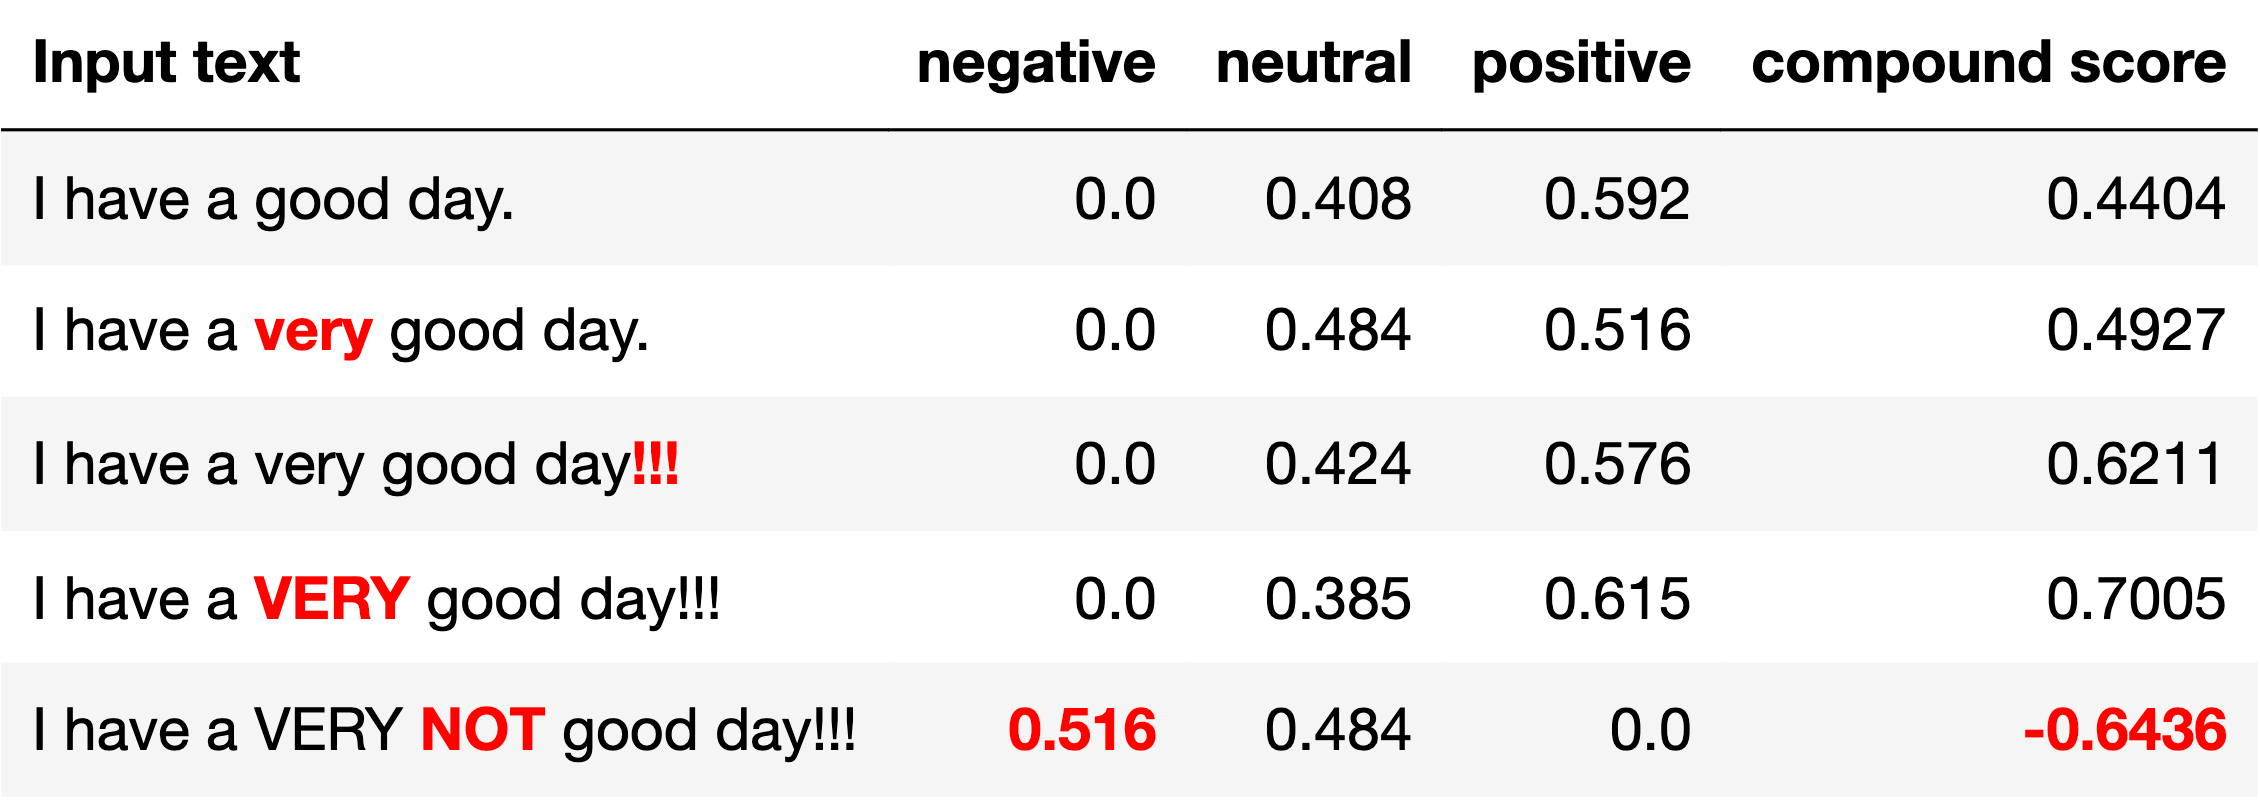

Let's fill our function analyze_food_sentiment() with  `input_text` and `polarity_calculator="vader"`. It runs quite fast.

⚠️ Please pay attention to the results of the processed sentences.

💭 Are they really negative/positive/neutral considering the context of food security?

In [ ]:
test_polarity_result_vader = analyze_food_sentiment(big_test_doc, polarity_calculator="vader")
print(big_test_doc)
#print(test_polarity_result_vader)

# Print polarized entities
print("\nPolarized entities:")
for entity in test_polarity_result_vader["polarizedEntities"]:
    print(entity)

# Print processed neutral entities
print("\nProcessed sentences:")
for result in test_polarity_result_vader["polarizedSentences"]:
    print(result)

# Visualization
visualize_entities_overlapping(big_test_doc, test_polarity_result_vader)

Now again with VADER🐱‍👤, let's try the time expressions extraction with the HeidelTime⏱️ library.

The arguments are `input_text`, `polarity_calculator="vader"`, and `run_heideltime=True, reference_date="2021-09-30"`. It runs fast (around 4s/relevant_sentence).


Please pay attention to the results of the extracted time expressions in Polarized Entities:
* HeidelTime caught more time entities (**DATE** and **DURATION**).
* Was it useful to use a reference date? For which entities?
* What is the time value of the word "hier" (yesterday)?


In [ ]:
test_polarity_result_vader = analyze_food_sentiment(big_test_doc, polarity_calculator="vader", run_heideltime=True, reference_date="2021-09-30")
print(big_test_doc)
#print(test_polarity_result_vader)
# Print polarized entities
print("\nPolarized entities:")
for entity in test_polarity_result_vader["polarizedEntities"]:
    print(entity)

    # Print processed neutral entities
print("\nProcessed sentences:")
for result in test_polarity_result_vader["polarizedSentences"]:
    print(result)

visualize_entities_overlapping(big_test_doc, test_polarity_result_vader)

## 4.2 🤖 Transformers

With Vader, you may have noticed that it labelled as "POSITIVE" a sentence about a lower price for cotton (non edible crop), and "POSITIVE" for a general statement that the agricultural system is in "worrying" conditions. This might be caused by words like "prix" (French for "price"😟 but also for "award"😃) and "améliorer" (French for "improve" 😃).

😰 The synonymy and polysemy are problems for VADER.

🤔 What if we take into account the surrounding words that allows to know that "prix" in this text means "price" (a rise in prices) instead of a "award"? What if we achieve to detect that "améliorer" (improve) is something we have to do because the current situation is negative?

* Let's try now using transformers models for French language which take into account the context better than VADER, thanks to text embeddings.

* We simply set the parameter `polarity_calculator="transformers"` in our function.

* By default, it will use the HuggingFace model `ac0hik/Sentiment_Analysis_French` available here.




**💡💡 How can I use a different model for sentiment analysis?**

Feel free to test other HuggingFace models [available here](https://huggingface.co/models?language=fr&sort=trending&search=sentiment) by setting a new function's argument : `transf_model = "data354/camembert-fr-covid-tweet-sentiment-classification"` ([source](https://huggingface.co/data354/camembert-fr-covid-tweet-sentiment-classification))

In [ ]:
# OPTIONAL - add your HuggingFace personal token privately here to avoid errors
# Get your HF Access Token here https://huggingface.co/settings/tokens

import getpass
HF_API_TOKEN = getpass.getpass(prompt="Your HuggingFace API Key token")

In [ ]:
test_polarity_result_tf = analyze_food_sentiment(big_test_doc, polarity_calculator="transformers")
#print(test_polarity_result_vader)
# Print polarized entities
print("\nPolarized entities:")
for entity in test_polarity_result_tf["polarizedEntities"]:
    print(entity)

    # Print processed neutral entities
print("\nProcessed sentences:")
for result in test_polarity_result_tf["polarizedSentences"]:
    print(result)

visualize_entities_overlapping(big_test_doc, test_polarity_result_tf)

Where the 3 relevant sentences labelled correctly?

We know that if the food prices decrease, people will have better access to food. And it's likely that the prices are decreasing because the availability is increasing. But for non-edible crops, this is not relevant for food insecurity, so the sentence avoid cotton's prices must be labelled as `NEUTRAL`.

Fortunately, the sentence #3 was correctly labelled as `NEGATIVE`!

|Sentence |Output |Correct values|
|----------|----------|--|
|1 |Negative🎉|Negative|
|2 |Positive❌|Neutral|
|3 |Negative🎉|Negative|


The Transformer models we tested were doing better than VADER in general, but the results were not satisfactory because the pretrained models were trained using datasets for movies, wikipedia events or tweets about COVID outbreaks. There is no dataset on polarity analysis for food security.

What if we try a ChatBot🤖? (Large Language Models)


⬇️⬇️⬇️⬇️⬇️

## 4.3 LLM - (💥not working on G Colab)

A Transformer model is a language model because it stores data of how words are placed one after each other, so it learns which words are frequent neighbors of others. It also tries to learn that a if a word is placed just after the verb "eat", the word is probably a food (semantically similar words: fruits, vegetables, etc.).

The recent technologies allowed to train even larger language models, passing from an average of 400 Megabytes of data to 6 Gb, 70 Gb or even more. The more data, the better we know about a language (or many languages at once!).

Since Large language models (LLMs) contain mode data, they should capture better the details of a sentence to identify if it's neutral, positive or negative TAKING INTO ACCOUNT the domain of food security. So the model will identify if the sentence has any impact on food security and then evaluate the polarity accordingly.

---

We propose testing two versions:
* Local chatbot installed in your computer (keep reading)
* Remote chatbot by remote API keys (continue to the next section).

---

Let's try now (in your local computer) to run the polarity analysis in a local ChatBot [after installing Ollama](https://ollama.com/download):

1.   Execute this command in your terminal to see the list of downloaded models: `ollama list`.

2.   Copy the exact name of your large language model of preference, and run the server with the terminal command `ollama serve`.

3.   Paste the LLM's name in the hyperparameters at the begining of this notebook (`section 3`), or pass it directly as an argument to the function `Ollama_model = "MODEL_NAME"`.

Notes: this model does not require GPU. So far it's not supported but it could easily be adapted to run on GPU. The processing time could take around 30 seconds per relevant sentence in a document with a small phi3 LLM; 70s/it for Llama3 8B; 4min/it for Mixtral 7x8B.

Exemples of correct functions:

```
# Simple version by using the LLM_MODEL name set as Hyperparameter
analyze_food_sentiment(str, polarity_calculator="Ollama")

# Setting a different Ollama_model name
analyze_food_sentiment(str, polarity_calculator="Ollama", Ollama_model = "llama3:instruct")

# Enabling HeidelTime for better time entities
analyze_food_sentiment(str, polarity_calculator="Ollama", Ollama_model = LLM_MODEL, run_heideltime=True)

# Adding a reference date for HeidelTime
analyze_food_sentiment(str, polarity_calculator="Ollama", Ollama_model = LLM_MODEL, run_heideltime=True, reference_date="2021-09-30")
```



In [ ]:
#test_polarity_result_llm = analyze_food_sentiment(big_test_doc, polarity_calculator="Ollama")

# Print polarized entities
#print("\nProcessed neutral entities:")
#for entity in test_polarity_result_llm["polarizedEntities"]:
 #   print(entity)

# Print processed neutral entities
#print("\nProcessed sentences:")
#for result in test_polarity_result_llm["polarizedSentences"]:
    #print(result)

Once you get the output, please pay attention to the colors of underlined sentences and their labels.

* Is there any difference to the sentiment labels given to the relevant sentences by the previous models (Vader, Transformers)?
* Do you see the value of the entity's attribute: `cited_factors` and `concepts`?
* 💡 `Cited_factors` is a new information we get from the LLM to explain the sentiment's prediction. Is this output's information any helpful to explain the cause of a possible risk to food security? (this information is not visualized in the displaCy HTML render)
* 🔎 `Concepts` is not a new information compared to Vader and Transformers approaches. But it gives more specific information about the subcategory of risk factor. Our `theme_clustering` function asks the LLM to run a zero-shot text classification task to associate the cited factor to a subcategory of risk factor. So instead of "`price`", the concept became whether "`rise in transportation/fuel prices`", "`rise in food prices`" or "`rise in farming materials`". (this information is not visualized in the displaCy HTML render)

See an example of the output:

```
'polarizedSentences' : [
{'cited_factors': ["monte le coût de l'engrais"],
 'concepts': ['augmentation des prix des intrants agricoles'],
 'end_char': 58,
 'polarity_label': 'negative',
 'score': -1,
 'sentence': "La guerre est mauvaise car il monte le coût de l'engrais.",
 'start_char': 0,
 'themes': ['economique']}
 ```

## 4.4 ✨ Remote ChatOllama

This is an API service. The personal token can be given to researchers and students in Montpellier [via this link](https://forgemia.inra.fr/isdm-meso/isdm_chat).

It works similar as a local Ollama model, but it is limited to the model `mixtral:8x7b-instruct-v0.1-q5_0`.

The processing time is quite fast compared to the local model running on CPU: from 4min/it -> 17 seconds/it.

Please pay attention to the colors of underlined sentences and their labels.

* Is there any difference to the sentiment labels given to the relevant sentences by the previous models (Vader, Transformers)?
* Do you see the value of the entity's attribute: `cited_factors` and `concepts`?
* 💡 `Cited_factors` is a new information we get from the LLM to explain the sentiment's prediction. Is this output's information any helpful to explain the cause of a possible risk to food security? (this information is not visualized in the displaCy HTML render)
* 🔎 `Concepts` is not a new information compared to Vader and Transformers approaches. But it gives more specific information about the subcategory of risk factor. Our `theme_clustering` function asks the LLM to run a zero-shot text classification task to associate the cited factor to a subcategory of risk factor. So instead of "`price`", the concept became whether "`rise in transportation/fuel prices`", "`rise in food prices`" or "`rise in farming materials`". (this information is not visualized in the displaCy HTML render)

In [ ]:
import getpass

ISDM_TOKEN = getpass.getpass(prompt="Your ISDM_Chat API Key")
OPENAI_API_KEY = ISDM_TOKEN #For ISDM's Codestral model
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# USING OpenAI ? Please uncomment the following code. Not tested yet.

#OPENAI_API_KEY = getpass.getpass(prompt="Your ISDM_Codestral API Key")
#os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
#%pip install -qU langchain-openai
#from langchain_openai import ChatOpenAI
#from langchain_openai import OpenAIEmbeddings

# USING GROQ ? Please uncomment the folowing code
#GROQ_API_KEY = getpass.getpass(prompt="Your Groq API Key") # Not implemented yet

In [ ]:
#test_polarity_result_llm = analyze_food_sentiment(big_test_doc, polarity_calculator="isdm", run_heideltime=True, reference_date="2021-09-30")
test_polarity_result_llm = analyze_food_sentiment(big_test_doc, polarity_calculator="Codestral", run_heideltime=True, reference_date="2021-09-30")

# Print polarized entities
print("\nProcessed neutral entities:")
for entity in test_polarity_result_llm["polarizedEntities"]:
    print(entity)

# Print processed neutral entities
print("\nProcessed sentences:")
for result in test_polarity_result_llm["polarizedSentences"]:
    print(result)

visualize_entities_overlapping(big_test_doc, test_polarity_result_llm)

# 5.📚 Applying the whole pipeline to a dataset

Let's try now to apply our analyzer function in batch for **many documents**.

The next blocks will:

1.   Download a sample of documents linked to food insecurity in French language.
2.   Run the analyzer in a unique document (choose between 0 and 29).
3.   Run the whole analyzer for the whole pack of 30 documents.
4.   Download an HTML file with the colourful render of the output.
5.   Download an Excel file with the data output.



## 5.1 🔎 Analyzing one document from many

In [ ]:
import pandas as pd

In [ ]:
# Load df from excel
#dataset = pd.read_excel("../data/BF405_entities_kw_polarity.xlsx")
#!wget https://github.com/tetis-nlp/food-insecurity-risk-mining/raw/main/src/BF30_sample.xlsx -P /content

#dataset = pd.read_excel("/content/BF30_sample.xlsx")
#dataset = pd.read_excel("/content/BF405_entities_phase_240415.xlsx")
senegal_path = "/content/df_senegal_food.xlsx"
dataset = pd.read_excel(senegal_path, header=0)

In [ ]:
# Adding publication dates to the dataframe
dates_df = pd.read_excel("/content/date_BF_2022.xlsx")
dates_df.info()

In [ ]:
dataset_with_dates = pd.merge(dataset, dates_df, on='id', how='inner')

In [ ]:
# Rename year_month to pub_date
dataset = dataset.rename(columns={'published_at': 'pub_date'})
dataset.info()

In [ ]:
# Find ids in dataset but not in merged_df
left_out_ids = set(dataset['id']) - set(dataset_with_dates['id'])
print(left_out_ids)

Let's select a random single document.

👉 Please change the value of `row_number` to any number between 0 to 29.

In [ ]:
# Print the value in the row 21 and column  "text"
row_number = 148
test_row_text = dataset_with_dates.loc[row_number, "text"]
test_row_date = dataset_with_dates.loc[row_number, "pub_date"]

# Apply the food sentiment analysis function to the text in the row 21
#test_polarity_result = analyze_food_sentiment(test_row_text, polarity_calculator="Codestral", run_heideltime=True, reference_date=test_row_date)
test_polarity_result = analyze_food_sentiment(test_row_text, polarity_calculator="vader", run_heideltime=True, reference_date=test_row_date)

# Raw print of the result
print("\n\n")
print(test_polarity_result)

print("\n\nPolarized Sentences :")
answer_sentences = test_polarity_result["polarizedSentences"]
for sent in answer_sentences:
  print("\t"+ str(sent))

# HTML render of the entities and sentences
visualize_entities_overlapping(test_row_text, test_polarity_result)


## 5.2 🔗Analyzing many or ALL documents in a dataset

Let's apply the food sentiment analysis function to every text (document) in the dataset. The processing time of the whole dataset (30 documents) could take around 35 minutes with the ChatOllama model, so we will only run the batch function `apply_food_sentiment_analysis(df)` to the first 3 rows in the dataframe.

In [ ]:
from tqdm import tqdm
tqdm.pandas()

def apply_food_sentiment_analysis(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    def analyze_row(row):
        try:
            return analyze_food_sentiment(row['text'], polarity_calculator="Codestral", run_heideltime=True, reference_date=row['pub_date'])
        except Exception as e:
            # Log the exception with specific details about the row and error message
            logging.error(f"Error processing dataframe's row: {row['id']}, Error: {str(e)}")
            return None  # Return None or any other value that signifies failure
    # Apply the analysis function to each row, handling exceptions
    df_copy['analysis_result'] = df_copy.progress_apply(analyze_row, axis=1)

    # Process the analysis results to create new columns
    if not df_copy.empty:
        df_copy['LOC_spaCy'] = df_copy['analysis_result'].apply(lambda x: [entity for entity in x['polarizedEntities'] if entity['label'] == 'LOC'] if x else [])
        df_copy['TIME_HeidelTime'] = df_copy['analysis_result'].apply(lambda x: [entity for entity in x['polarizedEntities'] if entity['label'] in ['TIME', 'DURATION', 'DATE']] if x else [])
        df_copy['polarizedEntities'] = df_copy['analysis_result'].apply(lambda x: [entity for entity in x['polarizedEntities'] if entity['label'] not in ['LOC', 'TIME', 'DURATION', 'DATE']] if x else [])
        df_copy['polarizedSentences'] = df_copy['analysis_result'].apply(lambda x: x['polarizedSentences'] if x else [])

        df_copy['LOC'] = df_copy['analysis_result'].apply(lambda x: [entity['text'] for entity in x['polarizedEntities'] if entity['label'] == 'LOC'] if x else [])
        df_copy['TIME'] = df_copy['analysis_result'].apply(lambda x: [entity['text'] for entity in x['polarizedEntities'] if entity['label'] in ['TIME', 'DURATION', 'DATE']] if x else [])
        df_copy['polEntity'] = df_copy['analysis_result'].apply(lambda x: [entity['text'] for entity in x['polarizedEntities'] if entity['label'].upper() not in ['LOC', 'TIME', 'DURATION', 'DATE', 'ORG', 'PER', 'MISC']] if x else [])

    # Drop the 'analysis_result' column as it's no longer needed
    #df_copy.drop(columns=['analysis_result'], inplace=True)

    return df_copy

# Apply the function to the DataFrame
analyzed_df = apply_food_sentiment_analysis(dataset)


In [ ]:
# Export df to excel file
output_path = "/content/Senegal689_entitites_17-07-24.xlsx"
analyzed_df.to_json('senegal689_foodsecurity_entities_17-07-24.jsonl', orient='records', lines=True)
analyzed_df.to_excel(output_path, index=False)

##5.3🎨 Batch-visualization from output file

These blocks will load the output (scores, risk factors and sentences) from a Excel file to then:
* visualize all the document's entities in this Jupyter notebook
* export the visualization to an HTML file

In [ ]:
import pandas as pd
import spacy
from spacy.tokens import Span
from spacy import displacy
import re
import ast  # To safely evaluate string literal to dictionary
from tqdm import tqdm

import ast
from tqdm import tqdm

def apply_visualize_entities_overlapping(df):
    total_rows = df.shape[0]
    compiled_html = ""  # Step 1: Initialize the compiled HTML content

    for index, row in tqdm(df.iterrows(), total=total_rows, desc="Processing rows in the dataset"):
        input_text = row['text']
        analysis_result = row['analysis_result']

        # Check if analysis_result is a string
        if isinstance(analysis_result, str):
            try:
                analysis_result = ast.literal_eval(analysis_result)
            except ValueError as e:
                print(f"Failed to evaluate string as literal at index {index}: {e}")
                continue

        try:
            my_html = visualize_entities_overlapping(input_text, analysis_result, export=True)

            # Handle the potential None return
            if my_html is None:
                print(f"Warning: visualize_entities_overlapping returned None for index {index}")
                my_html = ""  # Replace None with an empty string to avoid the error
        except Exception as e:
            print(f"Error visualizing entities for index {index}: {e}")
            my_html = ""  # Replace None with an empty string to avoid the error

        # Step 4: Append the heading with index information
        compiled_html += f"<h2>Visualization for the document in index: {index} out of {total_rows}</h2>"
        compiled_html += my_html  # Append the generated HTML content

        # Step 5: Append a horizontal bar after each visualization
        compiled_html += "<hr>"

    # Step 6: Return the compiled HTML content
    return compiled_html

# Open excel file
dataset_results = pd.read_excel("/content/BF405_mapped_events_v2_17-07-24.xlsx", header=0)

# Apply the function to the dataset
compiled_html = apply_visualize_entities_overlapping(dataset_results)
#compiled_html = apply_visualize_entities_overlapping(analyzed_df)

# Save the compiled HTML content to a file
with open("/content/entity_visualizations_BF405_17-07-24.html", "w") as file:
    file.write(compiled_html)

#6.⏱ Understanding the temporal entities

In the previous code, we used Timexy and HeidelTime libraries to extract time-related entities, such as dates (2024-07-01), times ("at noon"), durations ("3 months"), and relative temporal expressions ("last week").

Timexy and HeidelTime use the [Timex3 universal standard](https://timeml.github.io/site/publications/specs.html) for representing these entities.

👁‍🗨 Let's see some examples:

## **Results for timexy (default):**

* INPUT = "Today is the 10.10.2010. I was in Paris for six years."

* OUTPUT =

```
>>> 10.10.2010	      timexy	    TIMEX3      type="DATE"     value="2010-10-10T00:00:00"
>>> 21 juillet 1969     timexy      TIMEX3      type="DATE"     value="1969-07-21T00:00:00"
>>> un an               timexy      TIMEX3      type="DURATION"     value="P1Y"
```

## **Results for HidelTime ([online demo](https://heideltime.ifi.uni-heidelberg.de/heideltime/)):**

test_polarity_result_llm = analyze_food_sentiment(text, **run_heideltime=True**, reference_date = "2024-06-15")

```
>>> <TIMEX3 tid="t1" type="DATE" value="2024-06-15">Demain</TIMEX3> il sera
>>> <TIMEX3 tid="t2" type="DATE" value="2024-06-18">mardi</TIMEX3> le 10.10.2010. J'étais à Paris
>>> <TIMEX3 tid="t3" type="DATE" value="1969-07-21">le 21 juillet 1969</TIMEX3>.
>>> La pluie a tardé <TIMEX3 tid="t9" type="DURATION" value="P1Y">un an</TIMEX3>.
```

## **Résultat de Microsoft COPILOT (Few-shots extraction - LLM):**

Here are the TimeML TIMEX3 annotations for your French text:

* INPUT = “**Demain** il sera **10.10.2010**. J’étais à Paris le **21 juillet 1969**. La pluie a tardé **un an**.”
* OUTPUT =

```
>>> Demain              timexy      TIMEX3      type=“DATE”     value=“2010-10-09T00:00:00”
>>> 10.10.2010          timexy      TIMEX3      type=“DATE”     value=“2010-10-10T00:00:00”
>>> 21 juillet 1969     timexy      TIMEX3      type=“DATE”     value=“1969-07-21T00:00:00”
>>> un an               timexy      TIMEX3      type=“DURATION” value=“P1Y”
```